In [7]:

pip install dotenv

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["OPENAI_API_KEY"] = ""

In [16]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

In [17]:
llm = ChatOpenAI(model="gpt-4o-mini")


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])


In [18]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

In [19]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()


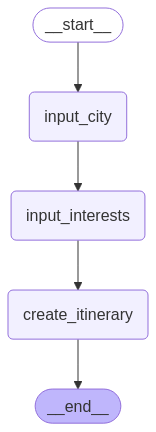

In [20]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [21]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }
    
    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing


In [22]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:
Please enter your interests for the trip to London (comma-separated):
Creating an itinerary for London based on interests: strips clubs...

Final Itinerary:
Here's a day trip itinerary for exploring some of London's strip clubs, keeping in mind a fun yet respectful approach. 

### London Day Trip Itinerary: Adult Entertainment

#### Morning
- **10:00 AM - Breakfast**
  - Start your day at **The Breakfast Club** in Soho for a hearty breakfast to fuel your day.
  
#### Late Morning
- **11:30 AM - Stroll Around Soho**
  - Explore the vibrant Soho area, known for its nightlife, including checking out some of the bars and clubs along the way.

#### Afternoon
- **1:00 PM - Lunch**
  - Enjoy lunch at **Dishoom** for a taste of Indian cuisine in a beautiful setting.
  
- **2:30 PM - Visit a Strip Club**
  - Head to **The Windmill** - a well-known venue featuring a mix of performances in a li